In [1]:
import os
import numpy as np
# import working directory to check functions
os.chdir('/Users/Dominik/R-workspace/cecelia/inst')

# MacOS
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'

# config
import py.config_utils as cfg

%load_ext autoreload
%autoreload 2

In [2]:
base_dir = '/Volumes/USER_data/Dominik/CECELIA_BACKUP/8BR53W/ANALYSIS/'
zero_dir = os.path.join(base_dir, '0/INglID/')
im_path = os.path.join(zero_dir, 'ccidAfCorrected.zarr')
version_num = 1
task_dir = os.path.join(base_dir, str(version_num), 'INglID')

In [21]:
import py.zarr_utils as zarr_utils

im, _ = zarr_utils.open_as_zarr(im_path, as_dask = True)

<zarr.hierarchy.Group '/' read-only>


In [7]:
import py.correction_utils as correction_utils
import py.slice_utils as slice_utils

In [22]:
import py.ome_xml_utils as ome_xml_utils
from py.dim_utils import DimUtils

# get OME-XML
omexml = ome_xml_utils.parse_meta(im_path)

# create dim utils for image
dim_utils = DimUtils(omexml, use_channel_axis = True)
dim_utils.calc_image_dimensions(im[0].shape)

[181, 4, 33, 513, 515]
[515, 513, 33, 4, 181]
['X', 'Y', 'Z', 'C', 'T']


In [23]:
slices = [slice(None) for _ in range(len(im[0].shape))]
slices[dim_utils.dim_idx('C')] = slice(1, 2, 1)
slices = tuple(slices)

In [33]:
.shape

(513, 515)

{'tl': dask.array<min-aggregate, shape=(3,), dtype=int64, chunksize=(1,), chunktype=numpy.ndarray>, 'br': dask.array<max-aggregate, shape=(3,), dtype=int64, chunksize=(1,), chunktype=numpy.ndarray>}
(33, 513, 515)
(slice(None, None, None), slice(dask.array<add, shape=(), dtype=int64, chunksize=(), chunktype=numpy.ndarray>, dask.array<sub, shape=(), dtype=int64, chunksize=(), chunktype=numpy.ndarray>, 1), slice(dask.array<add, shape=(), dtype=int64, chunksize=(), chunktype=numpy.ndarray>, dask.array<sub, shape=(), dtype=int64, chunksize=(), chunktype=numpy.ndarray>, 1))


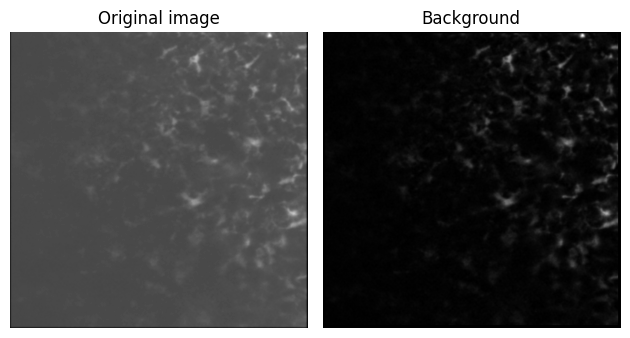

In [41]:
from matplotlib import pyplot as plt

corrected = im[0][slices].copy()
corrected = correction_utils.apply_rolling_ball(corrected, dim_utils)

fig, ax = plt.subplots(nrows=1, ncols=2)

ax[0].imshow(im[0][slices][0, 0, 14, :, :], cmap='gray')
ax[0].set_title('Original image')
ax[0].axis('off')

ax[1].imshow(corrected[0, 0, 14, :, :], cmap='gray')
ax[1].set_title('Background')
ax[1].axis('off')

fig.tight_layout()

In [42]:
import napari

viewer = napari.viewer.Viewer()

napari.manifest -> 'skan' could not be imported: Could not find file 'napari.yaml' in module 'skan'


In [43]:
viewer.add_image(im[0], channel_axis=1)
viewer.add_image(corrected, channel_axis=1)

[<Image layer 'Image [4]' at 0x15fb90040>]

In [ ]:
for i in range(0, 5, 1):
    fig, axes = plt.subplots(1, 2, figsize=(6, 3))
    
    im = axes[0].imshow(images[i])
    fig.colorbar(im, ax=axes[0])
    axes[0].set_title("Original")
    
    im = axes[1].imshow(images_transformed[i])
    fig.colorbar(im, ax=axes[1])
    axes[1].set_title("Corrected")
    fig.suptitle(f"frame {i}")
    
    fig.tight_layout()

In [ ]:
import py.correction_utils as correction_utils

In [ ]:
import importlib
importlib.reload(correction_utils)

In [ ]:
a = correction_utils.af_correct_image(
    im[0], {
        0: {'divisionChannels': [], 'rollingBallRadius': 0},
        1: {'divisionChannels': [], 'rollingBallRadius': 40, 'rollingBallPadding' : 4},
    }, dim_utils = dim_utils
)

In [ ]:
import napari

viewer = napari.Viewer()

In [ ]:
viewer.add_image(a, channel_axis = dim_utils.dim_idx('C'))

In [ ]:
# crop zero edges
# https://stackoverflow.com/a/39466129
def crop_zero_edges(im):
    # argwhere will give you the coordinates of every non-zero point
    true_points = np.argwhere(im)
    
    # take the smallest points and use them as the top left of your crop
    top_left = true_points.min(axis=0)
    
    # take the largest points and use them as the bottom right of your crop
    bottom_right = true_points.max(axis=0)

    return {'tl': top_left, 'br': bottom_right}

In [ ]:
rolling_ball_radius = 40
rolling_ball_padding = 4

In [ ]:
import py.slice_utils as slice_utils

In [ ]:
# get slices
slices = slice_utils.create_slices(im.shape, dim_utils)
for i, x in enumerate(slices):
    x = list(x)
    x[dim_utils.dim_idx('C')] = slice(1, 2, 1)
    slices[i] = tuple(x)

In [ ]:
slices[1:2]

In [ ]:
import skimage
from skimage.restoration import rolling_ball
from skimage.morphology import disk

In [ ]:
cur_slices

In [ ]:
crop_slices

In [ ]:
im[cur_slices][crop_slices].shape

In [ ]:
# corrected_data = corrected_data - rolling_ball(corrected_data, radius = rolling_ball_radius)
# TODO go through in 2D as 3D seems a bit much
footprint = skimage.morphology.disk(rolling_ball_radius)

def apply_2D_rolling_ball(im, slices, dim_utils, radius = 40, padding = 4):
    im_to_process = np.squeeze(im[cur_slices])

    edges = crop_zero_edges(im_to_process)
    crop_slices = (
        slice(edges['tl'][0] + padding,
              edges['br'][0] - padding, 1),
        slice(edges['tl'][1] + padding,
              edges['br'][1] - padding, 1)
    )

    slices = list(slices)
    slices[dim_utils.dim_idx('Y')] = crop_slices[0]
    slices[dim_utils.dim_idx('X')] = crop_slices[1]
    slices = tuple(slices)
    
    im[slices] = rolling_ball(
        im_to_process[crop_slices], radius = radius)

# go through slices
for cur_slices in slices[1:2]:
    if dim_utils.is_3D():
        # go through Z
        for z in range(dim_utils.dim_val('Z')):
            print(f'> {z}')
            
            cur_slices = list(cur_slices)
            cur_slices[dim_utils.dim_idx('Z')] = slice(z, z+1, 1)
            cur_slices = tuple(cur_slices)
            
            apply_2D_rolling_ball(
                im, cur_slices, dim_utils, rolling_ball_radius, rolling_ball_padding)
    else:
        apply_2D_rolling_ball(
            im, cur_slices, dim_utils, rolling_ball_radius, rolling_ball_padding)

In [ ]:

import math

radius = 40
padding = 4



im_to_process = np.squeeze(im[slices])
edges = crop_zero_edges(im_to_process)
crop_slices = (
    slice(edges['tl'][0] + padding, edges['br'][0] - padding, 1),
    slice(edges['tl'][1] + padding, edges['br'][1] - padding, 1)
)

rolling_im = rolling_ball(im_to_process[crop_slices], radius = radius)

In [ ]:
dim_utils.is_timeseries()

In [ ]:
# corrected_data = corrected_data - rolling_ball(corrected_data, radius = rolling_ball_radius)
# TODO go through in 2D as 3D seems a bit much
footprint = skimage.morphology.disk(rolling_ball_radius)

if dim_utils.is_timeseries():

im_to_process = np.squeeze(im[slices])
edges = crop_zero_edges(im_to_process)
crop_slices = (
    slice(edges['tl'][0] + padding, edges['br'][0] - padding, 1),
    slice(edges['tl'][1] + padding, edges['br'][1] - padding, 1)
)

rolling_im = rolling_ball(im_to_process[crop_slices], radius = radius)

In [ ]:
# display results
import matplotlib.pyplot as plt
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 4),
                         sharex=True, sharey=True)

ax = axes.ravel()

# compute corrected image
corrected_im = np.zeros_like(im_to_process)
corrected_im[crop_slices] = im_to_process[crop_slices] - rolling_im

ax[0].imshow(im_to_process, cmap=plt.cm.gray)
ax[0].axis('Off')
ax[0].set_title('Image', fontsize=20)

ax[1].imshow(rolling_im, cmap=plt.cm.gray)
ax[1].axis('Off')
ax[1].set_title('Background', fontsize=20)

ax[2].imshow(corrected_im, cmap=plt.cm.gray)
ax[2].axis('Off')
ax[2].set_title('Corrected', fontsize=20)

fig.tight_layout()
plt.show()